#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96 #  (submerged) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # 32219000   # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.45783586, -0.86205777, -0.21735392],
       [ 0.57250573,  0.09883867,  0.81392144],
       [-0.68016433, -0.49707879,  0.5387849 ]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.008705


In [29]:
Ret.shape

(50, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000468


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.56060016e+04,  9.05094647e+03,  5.47039650e+04],
       [ 1.63304658e+01,  1.52811759e+03, -3.94001144e+03],
       [ 5.37350211e+03,  1.68243221e+04, -1.15444822e+04],
       [-1.13781973e+03, -6.33456541e+03, -1.14567906e+04],
       [ 1.52797875e+04, -1.26969010e+04, -2.74248573e+04],
       [ 3.02410422e+03, -1.20777493e+04, -4.10307388e+04],
       [-9.99701335e+03, -3.88947760e+03,  2.54448194e+03],
       [-4.41112693e+03, -2.14578566e+04, -4.84367581e+03],
       [ 8.33028211e+02,  3.71970585e+03, -6.01557630e+02],
       [-1.72088148e+03,  1.71101560e+03,  2.75938103e+03],
       [ 8.36845924e+02, -3.96253955e+02,  1.36133830e+03],
       [ 1.13768790e+03,  2.44869122e+03,  2.04283324e+03],
       [-4.50881732e+03,  1.76472498e+03,  1.10740067e+03],
       [-3.73718128e+02, -4.04413866e+02, -1.13258914e+02],
       [-1.72822959e+04, -6.08054605e+01, -1.88453298e+04],
       [-5.11685625e+02, -2.89403583e+03,  2.75385883e+03],
       [ 7.67428160e+03, -1.16942400e+04

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000269


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000860


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000133


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[-4.81314316e+01, -1.75247746e+01, -8.16844482e+01],
       [-1.03504610e+01,  1.51020401e+02,  2.30727661e+02],
       [ 4.80281334e+01,  9.43270874e+01, -3.67472763e+01],
       [ 1.07552322e+02,  1.31521164e+02,  3.11493816e+01],
       [-1.55600266e+02, -2.39394436e+01,  8.88923035e+01],
       [-1.00456482e+02, -5.95166473e+01, -1.27812004e+02],
       [-5.14321098e+01,  8.72783356e+01, -1.41604446e+02],
       [ 5.07306442e+01, -1.75653397e+02, -5.36527405e+01],
       [-7.26394424e+01,  5.75638733e+01, -4.89906578e+01],
       [ 1.26682907e+02, -1.12959599e+00,  1.92351349e+02],
       [ 1.90086105e+02,  5.13641129e+01, -6.62833548e+00],
       [-7.23786163e+01, -8.21152573e+01, -1.55882736e+02],
       [-3.98069930e+00, -1.29522522e+02, -7.29667053e+01],
       [-1.08265181e+01,  9.19145508e+01, -2.44157200e+01],
       [-1.09594299e+02,  7.64295435e+00, -1.38714020e+02],
       [ 8.13078995e+01, -1.31742386e+02, -1.82046986e+01],
       [-2.34985199e+02,  3.87503738e+01

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.001886


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.003153


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.002516


In [57]:
ωe(φ,θ,ψ,None,None)

array([[-1.09236726,  0.68361545,  0.36895533],
       [ 1.61091591, -0.08379219, -2.6486341 ],
       [ 0.30953548, -2.23237725, -1.1137387 ],
       [-0.73264442,  0.38488054, -0.34393215],
       [ 0.17441587, -0.2806187 ,  0.02934554],
       [ 0.66533833, -2.42159492, -0.58575712],
       [-1.43335735, -0.57127382, -0.43253562],
       [-0.89323229,  0.31019584,  0.25239808],
       [ 0.27864503,  1.36118202,  0.57489855],
       [ 0.53210275,  0.61809546,  0.61009137],
       [ 0.04572299, -1.87941613,  1.1429011 ],
       [ 0.63167479,  0.87717274,  0.40950103],
       [ 0.58494938, -1.16509044, -0.56877376],
       [-0.97867973,  1.23391991,  1.40900339],
       [-0.57334208,  0.55424864,  0.28383313],
       [ 0.54918883,  1.61028709,  2.77509038],
       [-1.19755412, -0.07927086,  0.53473886],
       [-0.58694072,  0.46990451, -1.51847035],
       [-1.06961265, -2.05540547, -0.94050184],
       [ 1.15084523, -2.01155894,  1.09682394],
       [ 0.24068488,  0.86289335, -0.621

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1,omega)
#     print(Ret.shape)
#     print(np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).shape)
    return  np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T
#     return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ -49.37489153,  380.66460771,  187.08951103,   57.22314809,
         -24.24232718,  274.64660011,  118.64590178,   27.69172297,
         -99.77858963,  119.58065239,  -46.24670069, -103.10980351,
          11.34379958, -159.63495613,  -79.05138094,  336.28223668,
         -18.92496961, -247.19957048, -475.28596474, -173.61902703,
           4.21593547,   76.21005709, -173.16026461,   47.84777736,
          41.52064056,  -46.48026392,  -60.09455514,   31.06026534,
          64.2687895 , -228.13288338, -103.6357647 , -441.25990424,
          24.9784102 , -175.24052755, -282.47711242,  -69.7344366 ,
         521.16345238,  116.76159698,   -3.24725612,   36.59664191,
         115.84180597,    3.95897096,  386.51905924,   54.19679324,
         286.24710617,   24.39054562,   10.76070438,   29.07850654,
         -43.13403635,    2.24591164],
       [-106.98776492, -344.26827588,  -42.11620473,  -14.16928137,
         -20.07040201,  143.8813249 , -180.72355379,  -35.12004289,
         

In [60]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.003113


In [61]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [62]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [63]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.56060016e+04, -1.63304658e+01, -5.37350211e+03,
         1.13781973e+03, -1.52797875e+04, -3.02410422e+03,
         9.99701335e+03,  4.41112693e+03, -8.33028211e+02,
         1.72088148e+03, -8.36845924e+02, -1.13768790e+03,
         4.50881732e+03,  3.73718128e+02,  1.72822959e+04,
         5.11685625e+02, -7.67428160e+03,  4.84052012e+03,
         3.92303943e+03,  3.56159610e+03, -4.26540963e+03,
        -1.31610732e+04,  3.15025447e+02, -1.47911417e+02,
        -9.78496645e+02, -8.44531965e+03, -4.68660268e+03,
         7.22698393e+03, -7.72372107e+03, -6.07795326e+03,
        -1.04990390e+04,  1.01396549e+03, -1.81518563e+03,
         2.57258646e+03,  8.74495007e+03,  1.53816068e+04,
        -3.79579594e+03, -1.61163378e+04, -8.34298480e+03,
         4.86668338e+03, -1.39647154e+03, -2.35651981e+04,
         1.76482154e+04, -5.47743371e+03,  1.62153806e+03,
        -7.37677328e+02,  1.75152945e+04, -2.07268368e+04,
         2.82751615e+03, -4.13204802e+01],
       [-9.05

In [64]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001796


In [65]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.04456214e+10, -1.05076521e+09,  1.53060907e+10],
       [ 2.46953122e+07, -1.26514050e+10,  1.51268361e+11],
       [ 2.32350299e+08, -3.87298891e+10,  7.23434584e+07],
       [ 1.80669301e+10, -3.53647687e+09, -7.46198278e+10],
       [-2.32089352e+10, -1.93406500e+10, -4.29735045e+10],
       [ 1.49016868e+11,  6.02214251e+10, -6.13577024e+10],
       [ 9.97156791e+10, -4.06500704e+09, -7.76922112e+08],
       [ 2.16612738e+10, -1.10440108e+10,  5.69554340e+10],
       [-1.24754026e+10, -2.68375334e+10,  1.63864102e+10],
       [ 3.55370099e+10, -1.15138711e+10, -4.90910376e+10],
       [-2.80499685e+09,  1.76116645e+11,  8.07244432e+09],
       [-2.02793037e+10,  3.32157736e+10,  4.44901265e+09],
       [ 1.42932311e+09,  2.83716081e+10, -2.14487031e+10],
       [-4.59450246e+10, -1.67018467e+08, -4.84021384e+08],
       [-5.06803838e+10, -6.22893289e+10,  2.39853184e+10],
       [ 4.18866791e+09,  2.33874116e+11, -2.42511950e+09],
       [-3.50124310e+08, -4.17096146e+09

In [66]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000936


In [67]:
Re_b(Ret).shape

(50, 3, 3)

In [68]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [69]:
Irho_e(Ret).shape

(50, 3, 3)

In [70]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000207


In [71]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [72]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [73]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [74]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.011069


In [75]:
d_me_

array([[ 1.97381315e+02,  2.55632183e+00,  6.68560581e+02],
       [ 3.54070014e-02,  6.28705280e+02, -1.29898175e+02],
       [-1.68554789e+01, -9.31919816e+01, -1.90489044e+00],
       [ 2.61471172e+01,  2.45839430e+02,  4.68896943e+02],
       [-2.39746232e+01, -9.99362209e+00,  4.99334156e+01],
       [ 4.14252417e+03,  2.68513551e+02,  1.31080153e+03],
       [ 3.36166956e+02,  2.27773844e+01, -1.33231644e+01],
       [ 1.23004022e+00, -1.46730768e+02,  2.35023147e+02],
       [ 1.72577356e+02,  4.24970737e+02, -2.44869370e+02],
       [ 3.07722815e+02,  3.06269842e+01, -6.05549820e+02],
       [ 3.39093057e+02,  2.04701051e+02,  4.31179322e+00],
       [ 4.49010314e+02, -7.89882827e+02, -2.45617109e+01],
       [-1.46864051e+02, -9.82729583e+01, -2.21441565e+02],
       [ 1.61091988e+03,  3.30431847e+00,  2.04893191e+01],
       [-1.97083856e+02, -4.26227291e+02,  3.57098272e+02],
       [ 2.12223578e+02,  1.62636279e+03, -5.13360477e+01],
       [ 3.50215566e+00, -5.38724169e+01

In [76]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.56060016e+04, -1.63304658e+01, -5.37350211e+03,
         1.13781973e+03, -1.52797875e+04, -3.02410422e+03,
         9.99701335e+03,  4.41112693e+03, -8.33028211e+02,
         1.72088148e+03, -8.36845924e+02, -1.13768790e+03,
         4.50881732e+03,  3.73718128e+02,  1.72822959e+04,
         5.11685625e+02, -7.67428160e+03,  4.84052012e+03,
         3.92303943e+03,  3.56159610e+03, -4.26540963e+03,
        -1.31610732e+04,  3.15025447e+02, -1.47911417e+02,
        -9.78496645e+02, -8.44531965e+03, -4.68660268e+03,
         7.22698393e+03, -7.72372107e+03, -6.07795326e+03,
        -1.04990390e+04,  1.01396549e+03, -1.81518563e+03,
         2.57258646e+03,  8.74495007e+03,  1.53816068e+04,
        -3.79579594e+03, -1.61163378e+04, -8.34298480e+03,
         4.86668338e+03, -1.39647154e+03, -2.35651981e+04,
         1.76482154e+04, -5.47743371e+03,  1.62153806e+03,
        -7.37677328e+02,  1.75152945e+04, -2.07268368e+04,
         2.82751615e+03, -4.13204802e+01],
       [-9.05

### Vessel

In [78]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [79]:
V=VesselSemisub()

In [80]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [81]:
tau_force = V.tau(η,dη, ddη)

In [82]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [83]:
wave_coef=1

In [84]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [85]:
Hs = 2.5 # significant wave height in m

In [86]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [87]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [88]:

def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    ans=np.concatenate( [F,[0,0,0]], axis=0)
    return ans

In [89]:
tau(η, dη, wave_coef, kp, kd,3)

array([9750.        ,    0.        , 7283.67179881,    0.        ,
          0.        ,    0.        ])

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [99]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

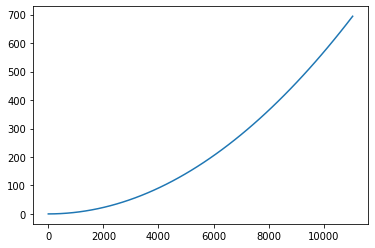

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)


    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
############################################################    

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
    return ans 

In [104]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [109]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [110]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [111]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

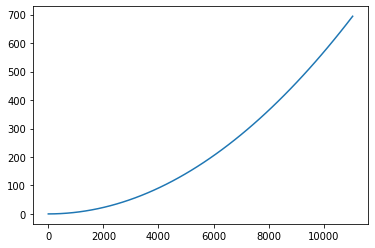

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[j*node_N-1]=0.13  

In [114]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Dynamics

In [115]:
def grayscott1d(t, Q):
    print(t)
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 5 sec
    if t<5:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
#     force_schedule = t/15 if t<15 else 1
    force_schedule =1
    tau_force = force_schedule*V.tau(η,dη,ddη).astype(np.float32) # /1e3
    


    Z0=np.dot(Re_b(Ret),tau_force[:3].reshape(3,1))

    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, test).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0.squeeze())

############################################################    
    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),Z).T
############################################################    

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

    C2= np.cross(test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           test))

    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 
#     print(ωe(φ,θ,ψ,None,None).shape)
#     C4= np.cross(d_s(phi,x,y,z,Ret, np.einsum('ijk,ik->ik',Ret,ωe(φ,θ,ψ,None,None))).T
#                  , ne(x,y,z,Ret,  np.einsum('ijk,ik->ik',Ret,ωe(φ,θ,ψ,None,None))))
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None).astype(np.float32)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None).astype(np.float32)))


    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [116]:
tspan = (0., 15)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
print(datetime.now() - startTime1)

0.0
5.544899515095214e-07
1.1089799030190428e-05
1.6634698545285642e-05
4.4359196120761714e-05
4.928799568973523e-05
5.544899515095214e-05
5.544899515095214e-05
0.0001663469854528564
0.00022179598060380855
0.0004990409563585692
0.0005483289520483044
0.0006099389466604735
0.0006099389466604735
0.0017189188496795163
0.0022734088011890376
0.005045858558736644
0.005538738515633997
0.006154838461755687
0.006154838461755687
0.017244637491946116
0.02278953700704133
0.0505140345825174
0.05544283415149092
0.061603833612707826
0.061603833612707826
0.07858451850759508
0.0870748609550387
0.12952657319225686
0.1370735442566512
0.1465072580871441
0.1465072580871441
0.07231243572739565
0.07766673678473957
0.10443824207145913
0.10919762078909817
0.11514684418614696
0.11514684418614696
0.12585544630083478
0.1312097473581787
0.15798125264489826
0.1627406313625373
0.1686898547595861
0.1686898547595861
0.18284355596136423
0.18992040656225329
0.22530465956669862
0.23159519343415558
0.23945836076847676
0.23

6.087173112215689
6.146169271544901
6.1566574776478715
6.169767735276586
6.169767735276586
6.191613936517884
6.202537037138533
6.257152540241777
6.266861963015688
6.2789987414830755
6.2789987414830755
6.3014231197616155
6.3126353089008855
6.3686962545972365
6.378662644943255
6.391120632875777
6.391120632875777
6.415983665484484
6.428415181788838
6.490572763310608
6.501623000025589
6.515435795919315
6.515435795919315
6.541724561668793
6.554868944543531
6.620590858917224
6.632274754805881
6.646879624666702
6.646879624666702
6.6720982439132825
6.6847075535365725
6.747754101653025
6.758962376873728
6.772972720899606
6.772972720899606
6.796637428055472
6.8084697816334065
6.8676315495230735
6.878149197147903
6.89129625667894
6.89129625667894
6.915511992475195
6.927619860373322
6.988159199863958
6.998921749106738
7.012374935660213
7.012374935660213
7.039243320043519
7.052677512235172
7.119848473193437
7.131789977363795
7.146716857576743
7.146716857576743
7.175839225474795
7.190400409423821
7.

10.82743046644731
10.83382196182545
10.834958227670453
10.836378559976707
10.836378559976707
10.838929191427816
10.84020450715337
10.84658108578114
10.847714699759413
10.84913171723225
10.84913171723225
10.85155932670622
10.852773131443204
10.858842155128126
10.859921092672113
10.861269764602095
10.861269764602095
10.850887486397534
10.851765370980177
10.856154793893387
10.856935135744624
10.85791056305867
10.85791056305867
10.859666332223954
10.860544216806597
10.864933639719807
10.865713981571044
10.86668940888509
10.86668940888509
10.868441248551127
10.869317168384145
10.873696767549234
10.874475362956362
10.87544860721527
10.87544860721527
10.877025629023997
10.877814139928361
10.881756694450178
10.882457593031834
10.883333716258905
10.883333716258905
10.884759097583085
10.885471788245175
10.889035241555625
10.889668744366372
10.890460622879806
10.890460622879806
10.891787004055463
10.892450194643292
10.895766147582433
10.89635565032717
10.89709252875809
10.89709252875809
10.898343

11.18506673748381
11.185486151826064
11.185486151826064
11.186478248659872
11.186974297076777
11.189454539161298
11.189895471087436
11.190446635995107
11.190446635995107
11.191497586175148
11.192023061265168
11.19465043671527
11.195117525684177
11.19570138689531
11.19570138689531
11.196696949679593
11.197194731071734
11.199683638032443
11.200126110381014
11.200679200816726
11.200679200816726
11.196506739298322
11.196909415499826
11.198922796507354
11.199280730908692
11.199728148910365
11.199728148910365
11.200509950497937
11.20090085129172
11.202855355260647
11.203202822632901
11.203637156848218
11.203637156848218
11.200402283340981
11.20073935055629
11.202424686632831
11.202724301935326
11.203098821063447
11.203098821063447
11.203711737728254
11.204018196060657
11.205550487722673
11.205822895129254
11.20616340438748
11.20616340438748
11.20672703557637
11.207008851170814
11.208417929143037
11.208668431893654
11.208981560331926
11.208981560331926
11.209511579218198
11.209776588661335
11

11.354976564662975
11.355227608536035
11.355541413377361
11.355541413377361
11.356113025109545
11.356398830975639
11.3578278603061
11.358081909964849
11.358399472038284
11.358399472038284
11.358962603215586
11.359244168804237
11.36065199674749
11.360902277270736
11.361215127924792
11.361215127924792
11.358868111710022
11.35910243154589
11.360274030725233
11.360482315023782
11.36074267039697
11.36074267039697
11.361211310068708
11.361445629904576
11.362617229083918
11.362825513382468
11.363085868755656
11.363085868755656
11.36115391330078
11.361359534752687
11.362387642012214
11.36257041663613
11.362798884916025
11.362798884916025
11.363210127819835
11.363415749271741
11.364443856531269
11.364626631155184
11.36485509943508
11.36485509943508
11.365267419538506
11.36547357959022
11.36650437984879
11.366687633228091
11.366916699952217
11.366916699952217
11.36729184891972
11.367479423403472
11.36841729582223
11.368584028696676
11.368792444789733
11.368792444789733
11.369140296649586
11.3693

11.468948565993363
11.46954808013482
11.469654660426633
11.469787885791401
11.469787885791401
11.470014606739502
11.470127967213552
11.470694769583803
11.470795534449625
11.470921490531904
11.470921490531904
11.471141275009833
11.471251167248797
11.471800628443617
11.471898310433808
11.472020412921546
11.472020412921546
11.47225939796388
11.472378890485048
11.472976353090884
11.473082568665253
11.473215338133217
11.473215338133217
11.473496897085118
11.47363767656107
11.474341573940825
11.47446671125278
11.474623132892726
11.474623132892726
11.474951509658647
11.47511569804161
11.475936639956414
11.476082585185711
11.476265016722335
11.476265016722335
11.47663617434914
11.476821753162541
11.477749647229553
11.4779146061748
11.478120804856358
11.478120804856358
11.478517489205583
11.478715831380196
11.47970754225326
11.479883846408471
11.480104226602485
11.480104226602485
11.480503977078161
11.480703852316001
11.481703228505193
11.48188089538327
11.482102978980869
11.482102978980869
11.

11.554971711256053
11.555064662210173
11.555180850902822
11.555180850902822
11.555377206359868
11.55547538408839
11.555966272731006
11.556053541823026
11.556162628188051
11.556162628188051
11.556347815718274
11.556440409483386
11.556903378308945
11.556985683877933
11.557088565839168
11.557088565839168
11.557263878148479
11.557351534303134
11.55778981507641
11.557867731658327
11.557965127385721
11.557965127385721
11.558136609702856
11.558222350861424
11.558651056654265
11.558727271017435
11.5588225389714
11.5588225389714
11.559012788529184
11.559107913308075
11.559583537202537
11.559668092561552
11.55977378676032
11.55977378676032
11.559998782699035
11.560111280668393
11.560673770515178
11.560773768710161
11.560898766453892
11.560898766453892
11.561160594163221
11.561291508017884
11.561946077291207
11.56206244516202
11.562207905000536
11.562207905000536
11.562502604730891
11.56264995459607
11.56338670392196
11.563517681579896
11.563681403652316
11.563681403652316
11.563993499958233
11.5

11.623360823098173
11.623360823098173
11.623528074516784
11.623611700226089
11.624029828772617
11.624104162736444
11.624197080191228
11.624197080191228
11.624394706657561
11.624493519890727
11.62498758605656
11.625075420041597
11.625185212522894
11.625185212522894
11.625413126114319
11.625527082910033
11.626096866888597
11.626198161818118
11.626324780480022
11.626324780480022
11.6265771758201
11.62670337349014
11.627334361840335
11.627446537547037
11.627586757180413
11.627586757180413
11.627848178177281
11.627978888675715
11.628632441167884
11.628748628277602
11.628893862164752
11.628893862164752
11.629154285586926
11.629284497298015
11.629935555853454
11.630051299596643
11.630195979275628
11.630195979275628
11.630436339017853
11.630556518888964
11.631157418244525
11.631264244796625
11.63139777798675
11.63139777798675
11.630333462785481
11.630402204540408
11.630745913315039
11.630807017097196
11.630883396824892
11.630883396824892
11.631020880334745
11.631089622089672
11.631433330864303

11.679196403656077
11.679270953193486
11.67964370088053
11.679709967136002
11.679792799955345
11.679792799955345
11.679962597803389
11.680047496727411
11.680471991347522
11.680547457057763
11.680641789195565
11.680641789195565
11.680831276329922
11.6809260198971
11.681399737732994
11.681483954237152
11.68158922486735
11.68158922486735
11.681793823236262
11.681896122420719
11.682407618343
11.682498550951404
11.682612216711911
11.682612216711911
11.682825149593437
11.6829316160342
11.683463948238012
11.683558585074246
11.683676881119538
11.683676881119538
11.683892021162423
11.683999591183865
11.684537441291075
11.684633059087913
11.68475258133396
11.68475258133396
11.684954040507996
11.685054770095013
11.685558418030102
11.685647955440785
11.685759877204138
11.685759877204138
11.68488610714715
11.684952870053745
11.68528668458672
11.685346029392582
11.68542021039991
11.68542021039991
11.6855537362131
11.685620499119695
11.685954313652669
11.686013658458531
11.68608783946586
11.686087839

11.729173395171413
11.729173395171413
11.729293684730031
11.729353829509341
11.729654553405886
11.729708015431939
11.729774842964504
11.729774842964504
11.729887236867553
11.729943433819077
11.7302244185767
11.7302743714225
11.730336812479749
11.730336812479749
11.730443285658264
11.73049652224752
11.730762705193808
11.730810026606482
11.730869178372323
11.730869178372323
11.730973981709786
11.731026383378516
11.73128839172217
11.731334970983266
11.731393195059633
11.731393195059633
11.731510789249159
11.731569586343921
11.731863571817735
11.731915835901969
11.73198116600726
11.73198116600726
11.732120509728723
11.732190181589456
11.732538540893113
11.732600471435985
11.732677884614576
11.732677884614576
11.732839970987813
11.732921014174432
11.733326230107522
11.733398268495629
11.73348831648076
11.73348831648076
11.733670469984723
11.733761546736705
11.734216930496617
11.73429788760949
11.73439908400058
11.73439908400058
11.734591123512532
11.73468714326851
11.735167242048389
11.7352

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()